# Задача

Реализуем pipeline с использование текстовых признаков catboost.

# Импорты


In [1]:
import re
from string import punctuation

import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import RussianStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
%matplotlib inline

from module.prepare_data import load_dataset, Preprocessor

In [2]:
RANDOM_SEED = 35

pd.set_option('display.max_colwidth', 100)

# Данные

In [3]:
test_path = '../data/test.csv'
train_path = '../data/short_train.csv'

In [4]:
df = load_dataset(train_path)
test_df = load_dataset(test_path)

# Обучение

In [21]:
def get_cb_pipeline(catboost_args):
    return Pipeline([
        ('preproc', Preprocessor('text')),
        ('clf', CatBoostClassifier(**catboost_args))
    ])

In [22]:
TEXT_PROCESSING = {
    "tokenizers": [{
        "tokenizer_id": "Space",
        "separator_type": 'ByDelimiter',
        "delimiter": " ",
        "lowercasing": "true",
        "sub_tokens_policy": 'SingleToken',
    },{
        "tokenizer_id": "Sense",
        "separator_type": 'BySense',
        "lowercasing": "true",
        "sub_tokens_policy": 'SingleToken',
    }],
    "dictionaries": [{
            "dictionary_id": "Word",
            "gram_order": "1",
            "max_dictionary_size": "50000",
            "occurrence_lower_bound": "3",
        }, {
            "dictionary_id": "BiGram",
            "gram_order": "2",
            "max_dictionary_size": "50000",
            "occurrence_lower_bound": "3",
        }, {
            "dictionary_id": "TriGram",
            "gram_order": "3",
            "max_dictionary_size": "50000",
            "occurrence_lower_bound": "3",
        }, {
            "dictionary_id": "Symbols_1",
            "token_level_type": "Letter",
            "gram_order": "1",
            "max_dictionary_size": "500",
            "occurrence_lower_bound": "1",
        }, {
            "dictionary_id": "Symbols_2",
            "token_level_type": "Letter",
            "gram_order": "2",
            "max_dictionary_size": "2500",
            "occurrence_lower_bound": "2",
        }, {
            "dictionary_id": "Symbols_3",
            "token_level_type": "Letter",
            "gram_order": "3",
            "max_dictionary_size": "10000",
            "occurrence_lower_bound": "10",
        }],
    "feature_processing": {
        "default": [{
                "dictionaries_names": [
                    "Symbols_1",
                    "Symbols_2",
                    "Symbols_3",
                    'Word',
                    "BiGram",
                    "TriGram",
                ],
                "feature_calcers": ["BoW"],
                "tokenizers_names": ["Space"]
            }, {
                "dictionaries_names": ["Symbols_1", 'Word'],
                "feature_calcers": ["NaiveBayes"],
                "tokenizers_names": ["Space"]
        }],
    }
}

In [23]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 100,
}

In [24]:
cb_pipeline = get_cb_pipeline(cb_params)

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [26]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.0s remaining:   45.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.1s finished


In [27]:
cv_scores

array([0.87646471, 0.88053434, 0.88381659, 0.8826038 , 0.88625179])

О, стало заметно лучше. Бейзлайна.

## Проверка на отложенном датасете

In [35]:
cb_pipeline = get_cb_pipeline()

In [28]:
cb_pipeline.fit(df[['text']], df['label'])

Learning rate set to 0.238417
0:	learn: 0.6254532	total: 59.2ms	remaining: 5.86s
1:	learn: 0.5779319	total: 113ms	remaining: 5.55s
2:	learn: 0.5498677	total: 168ms	remaining: 5.43s
3:	learn: 0.5290903	total: 224ms	remaining: 5.39s
4:	learn: 0.5153863	total: 279ms	remaining: 5.3s
5:	learn: 0.5057627	total: 334ms	remaining: 5.22s
6:	learn: 0.4990193	total: 386ms	remaining: 5.13s
7:	learn: 0.4936615	total: 439ms	remaining: 5.05s
8:	learn: 0.4875760	total: 492ms	remaining: 4.98s
9:	learn: 0.4840218	total: 547ms	remaining: 4.93s
10:	learn: 0.4810028	total: 602ms	remaining: 4.87s
11:	learn: 0.4785382	total: 655ms	remaining: 4.8s
12:	learn: 0.4765381	total: 713ms	remaining: 4.77s
13:	learn: 0.4754219	total: 767ms	remaining: 4.71s
14:	learn: 0.4744015	total: 823ms	remaining: 4.66s
15:	learn: 0.4727948	total: 880ms	remaining: 4.62s
16:	learn: 0.4704045	total: 936ms	remaining: 4.57s
17:	learn: 0.4693729	total: 989ms	remaining: 4.51s
18:	learn: 0.4675882	total: 1.05s	remaining: 4.49s
19:	learn: 0

Pipeline(steps=[('preproc',
                 <module.prepare_data.Preprocessor object at 0x7fcc2ec8e2e8>),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7fcc2f15e400>)])

In [30]:
test_label = test_df['label']
test_prediction = cb_pipeline.predict_proba(test_df[['text']])[:, 1]

In [31]:
roc_auc_score(test_label, test_prediction)

0.8859514424269288

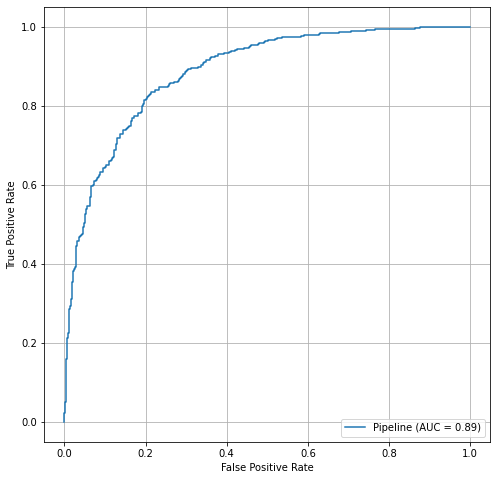

In [32]:
fg, ax = plt.subplots(1, 1, figsize=(8,8))
plot_roc_curve(cb_pipeline, test_df[['text']], test_label, ax=ax)
plt.grid()